In [1]:

import gzip
import math
import numpy as  np
import random
import sklearn
import string
from collections import defaultdict
import json
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def parseData(file):
    for l in open(file,'r'):
        yield json.loads(l)

In [2]:
dataset2 = []
dataset2 = list(parseData('renttherunway_final_data.json'))

In [3]:
count = 0 
for i in dataset2:
    try:
        _ = i['weight']
    except:
        count+=1
print("Percentage of user did not enter weight: " , count/len(dataset2))

count = 0 
for i in dataset2:
    try:
        _ = i['height']
    except:
        count+=1
print("Percentage of user did not enter height: " , count/len(dataset2))

count = 0 
for i in dataset2:
    try:
        _ = i['bust size']
    except:
        count+=1
print("Percentage of user did not enter bust size: " , count/len(dataset2))

Percentage of user did not enter weight:  0.15571505733754362
Percentage of user did not enter height:  0.0035160794415821837
Percentage of user did not enter bust size:  0.09561970250955626


In [4]:
dataset2[1]

{'fit': 'fit',
 'user_id': '273551',
 'bust size': '34b',
 'item_id': '153475',
 'weight': '132lbs',
 'rating': '10',
 'rented for': 'other',
 'review_text': 'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. ',
 'body type': 'straight & narrow',
 'review_summary': 'I felt so glamourous!!!',
 'category': 'gown',
 'height': '5\' 6"',
 'size': 12,
 'age': '36',
 'review_date': 'June 18, 2013'}

In [5]:
## We see a large percentage of users selected fit. 


fit_count = defaultdict(int)
for i in dataset2:
    fit_count[i['fit']]+=1
fit_count

defaultdict(int, {'fit': 142058, 'small': 25779, 'large': 24707})

In [98]:
fittingPerUser = defaultdict(list)
fittingPerItem = defaultdict(list)
allFitting = []
bust_sizes = set()
for entry in dataset2:
    item_id = entry['item_id']
    user_id = entry['user_id']
    fit = entry['fit']
    bust = entry.get('bust size',None)
    # bust_sizes.add(weight)
    height = entry.get('height', None)
    weight = entry.get('weight', None)
    size = entry['size']
    if fit == "fit":
        fit = 3
    elif fit == "small":
        fit = 1
    elif fit == 'large':
        fit = 5
        
    fittingPerUser[user_id].append((item_id,fit))
    fittingPerItem[(item_id,size)].append((user_id,fit))
    

    
    if bust != None:
        bust = int(bust[:2])
        
    if height != None:
        numbers = []
        for letter in height:
            if letter.isnumeric():
                numbers.append(int(letter))
        height_in_cm = 0
        height_in_cm += numbers[0]*30.48
        inches = ''
        for number in numbers[1:]:
            inches += str(number)
            
        height_in_cm += int(inches)* 2.54
        height = height_in_cm
    
    if weight != None:
        weight = int(weight[:-3])
    allFitting.append((user_id, item_id, fit, bust ,height, weight,size))
    


In [99]:

print('Size of the dataset :', len(dataset2))
lengths = []
for u in fittingPerUser:
    lengths.append(len(fittingPerUser[u]))
print("average fitting per user :", np.array(lengths).mean())
print('number of unique users: ', len(lengths))
lengths = []
for i in fittingPerItem:
    lengths.append(len(fittingPerItem[i]))

print("average fitting per item :", np.array(lengths).mean())
print('number of unique items: ', len(lengths))

print('-----------------------------')
print("Remove users with too few reviews")
print('-----------------------------')
removed_user_set = set()
lengths = []
for u in fittingPerUser:
    if len(fittingPerUser[u])>2:
        lengths.append(len(fittingPerUser[u]))
    else:
        removed_user_set.add(u)
        
print("average fitting per user post filterng :", np.array(lengths).mean())
print("total number of users post filtering :", len(lengths))

removed_item_set = set()
lengths = []
for i in fittingPerItem:
    if len(fittingPerItem[i])>2:
        lengths.append(len(fittingPerItem[i]))
    else:
        removed_item_set.add(i)
print("average fitting per item post filterng :", np.array(lengths).mean())
print("total number of items post filtering :", len(lengths))


Size of the dataset : 192544
average fitting per user : 1.8238341968911918
number of unique users:  105571
average fitting per item : 6.248385526529288
number of unique items:  30815
-----------------------------
Remove users with too few reviews
-----------------------------
average fitting per user post filterng : 5.3576835730507195
total number of users post filtering : 15852
average fitting per item post filterng : 9.983508590472907
total number of items post filtering : 17403


In [100]:
### Setting up the data for training and testing

users = list(fittingPerUser.keys())
items = list(fittingPerItem.keys())
userIDs = {}
itemIDs = {}
print("Length of pre-cleaned data:", len(allFitting))

    
# random.shuffle(allFitting)
# filtered_allFitting = []
# for u,i,f in allFitting:
#     if u in removed_user_set or i in removed_item_set :
#         continue
#     filtered_allFitting.append((u,i,f))
# print("Length of cleaned data:", len(filtered_allFitting))
filtered_allFitting  = allFitting
nTrain = int(len(filtered_allFitting)*0.8)
nTest = int(len(filtered_allFitting)-nTrain)
interactionsTrain =  filtered_allFitting[:nTrain]
interactionsTest = filtered_allFitting[nTrain:]

bust_list = []
height_list = []
weight_list = []


fittingPerUser_train = defaultdict(list)
fittingPerItem_train = defaultdict(list)

for u,i,f, b,h,w , size in interactionsTrain:
    # if u in removed_user_set or i in removed_item_set :
    #     continue
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not (i,size) in itemIDs: itemIDs[(i,size)] = len(itemIDs)
    
    if b != None: bust_list.append(b)
    if h != None: height_list.append(h)
    if w != None: weight_list.append(w)
    
    fittingPerUser_train[u].append((i,f))
    fittingPerItem_train[(i,size)].append((u,f))
    
# normalizing the features

bust_list = np.array(bust_list)
height_list = np.array(height_list)
weight_list = np.array(weight_list)

bust_average = bust_list.mean()
height_average = height_list.mean()
weight_average = weight_list.mean()

bust_std = bust_list.std()
height_std = height_list.std()
weight_std = weight_list.std()

user_space_full = {}

for u,i,f, b,h,w ,size  in interactionsTrain:
    if h!= None and w != None:
        user_space_full[u] = ((h-height_average)/height_std,
                        (w-weight_average)/weight_std)

print(len(user_space_full))
# keeping only the best user
userPerSizes  = defaultdict(list)
for user, size in user_space_full.items():
    userPerSizes[size].append(user)

inv_user_space = {}
for size in userPerSizes:
    best_user = None
    max_length = 0 
    for user in userPerSizes[size]:
        l = len(fittingPerUser_train[user])
        if l > max_length:
            max_length = l
            best_user = user
    inv_user_space[size] = best_user
print(len(inv_user_space))
user_space = {v: list(k) for k, v in inv_user_space.items()}



Length of pre-cleaned data: 192544
74697
1707


In [126]:

import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(0.01)
# mean_fitting = np.array([i[2] for i in allFitting]).mean()


class LatentFactorModel(tf.keras.Model):
    def __init__(self,  K, lamb1, lamb2):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        # self.alpha = tf.Variable(mu,dtype='float32')
        # Initialize to small random values

        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001),dtype='float32')
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001),dtype='float32')
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001),dtype='float32')
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001),dtype='float32')
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        # self.delta = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001),dtype='float32')

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = 3 + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
                # self.delta[i]*size
        return p

    # Regularizer
    def reg(self):
        return self.lamb1 * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2)) +\
                            self.lamb2*(tf.reduce_sum(self.gammaU**2) +\
                            tf.reduce_sum(self.gammaI**2))
    
    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        # s = tf.convert_to_tensor(sampleS, dtype=tf.int32)
        # size = tf.convert_to_tensor(size, dtype=tf.float32)
        
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        # delta = tf.nn.embedding_lookup(self.delta, s)
        pred = 3 + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1) 
               
        return pred
    
    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

# %%
def trainingStep(model, small, fit, large):
    Nsamples = 60000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR, sampleS , sizes = [], [], [], [], []
        for _ in range(Nsamples//3):

            u,i,r,s = random.choice(small)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[(i,s)])
            sampleR.append(r)
            # sampleS.append(itemIDs[i])
            # sizes.append(s)
            
            u,i,r,s = random.choice(fit)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[(i,s)])
            sampleR.append(r)
            # sampleS.append(itemIDs[i])
            # sizes.append(s)
            
            u,i,r,s = random.choice(large)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[(i,s)])
            sampleR.append(r)
            # sampleS.append(itemIDs[i])
            # sizes.append(s)
            
        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

# %%
modelLFM = LatentFactorModel( 5, 0.00002,0.00004)

# spliting the training based on fit:



In [127]:

small, fit, large = [], [], []

for u,i,r, _1,_2,_3, size in interactionsTrain:
    if r == 1:
        small.append((u,i,r,size))
    elif r == 3:
        fit.append((u,i,r,size))
    elif r == 5:
        large.append((u,i,r,size))

for i in range(300):
    obj = trainingStep(modelLFM, small, fit,large)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))


iteration 10, objective = 1.1886814
iteration 20, objective = 1.054542
iteration 30, objective = 0.94624513
iteration 40, objective = 0.86494064
iteration 50, objective = 0.80476975
iteration 60, objective = 0.764384
iteration 70, objective = 0.7294449
iteration 80, objective = 0.71053475
iteration 90, objective = 0.6986021
iteration 100, objective = 0.685838
iteration 110, objective = 0.67944247
iteration 120, objective = 0.67304
iteration 130, objective = 0.6671256
iteration 140, objective = 0.6636076
iteration 150, objective = 0.661658
iteration 160, objective = 0.6561433
iteration 170, objective = 0.6531614
iteration 180, objective = 0.65183944
iteration 190, objective = 0.6528641
iteration 200, objective = 0.65075713
iteration 210, objective = 0.64851034
iteration 220, objective = 0.6490654
iteration 230, objective = 0.649216
iteration 240, objective = 0.64719266
iteration 250, objective = 0.648688
iteration 260, objective = 0.64849705
iteration 270, objective = 0.6487593
iteratio

In [53]:
modelLFM.alpha

AttributeError: 'LatentFactorModel' object has no attribute 'alpha'

In [48]:
def out_to_fit(x):
    if x <=2:
        return 1
    elif x <= 4:
        return 3
    else:
        return 5
    
    
def find_nearest_user(user_space, b,h,w ):
    
    global height_average
    global height_std
    global weight_average
    global weight_std
    
    if h!= None and w != None:
        features = np.array([(h-height_average)/height_std,(w-weight_average)/weight_std])
        distance = 999999
        closest_user = None
        for user in user_space:
            distance2 = np.sum((features - np.array(user_space[user]))**2)
            if distance > distance2:
                closest_user = user
                distance = distance2
        return closest_user
    else:
        return None
    
correct = 0 
count = 0
for u,i,f, b,h,w  in interactionsTest:
    if u not in userIDs and i in itemIDs:
        closest_user =  find_nearest_user(user_space, b,h,w )
        if closest_user == None:
            ### U 
            average_item_fit = 0
            for u,f in fittingPerItem_train[i]:
                average_item_fit += f
            average_item_fit /= len(fittingPerItem_train[i])
            prediction = out_to_fit(average_item_fit)
        else:
            prediction = out_to_fit(modelLFM.predict(userIDs[closest_user],itemIDs[i]).numpy())
            
    elif u in userIDs and i not in itemIDs:
        continue
        
    elif u not in userIDs and i not in itemIDs:
        continue
    else:
        prediction = out_to_fit(modelLFM.predict(userIDs[u],itemIDs[i]).numpy())
    
    if prediction == f:
        correct += 1 

print(correct / len(interactionsTest))


ValueError: too many values to unpack (expected 6)

In [12]:
userIDs['452823']

65669

In [144]:
def average_auc_score(test):
    pred = []
    target = []

    for u,i,f, b,h,w ,s in test:
        # print(f)
        if u not in userIDs and (i,s) in itemIDs:
            closest_user =  find_nearest_user(user_space, b,h,w )
            if closest_user == None:
                ### U 
                average_item_fit = 0
                for u,f in fittingPerItem_train[(i,s)]:
                    average_item_fit += f
                average_item_fit /= len(fittingPerItem_train[(i,s)])
                prediction = average_item_fit

            else:
                prediction = modelLFM.predict(userIDs[closest_user],itemIDs[(i,s)]).numpy()

        elif u in userIDs and (i,s) not in itemIDs:
            prediction = 3
            
        elif u not in userIDs and (i,s) not in itemIDs:
            prediction = 3
        else:
            prediction = modelLFM.predict(userIDs[u],itemIDs[(i,s)]).numpy()   
        predict = max(min(prediction,5), 1) 
        pred.append(predict)
        target.append(f)

    pred_prob = np.zeros((len(test),3))
    for val_ind in range(len(pred)):
        val = pred[val_ind]
        prob1 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-1)/0.85)**2)
        prob2 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-3)/0.85)**2)
        prob3 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-5)/0.85)**2)
        sum_ = prob1 + prob2 + prob3

        pred_prob[val_ind][0] = prob1/sum_
        pred_prob[val_ind][1] = prob2/sum_
        pred_prob[val_ind][2] = prob3/sum_
        
        
    # print(pred_prob[:1000,:])
    # print(pred[:1000])
    
    AUC = []
    target_map = [1,3,5]
    weights = np.array([0.13,0.73,0.12])
    legend_map = ['ROC cureve of class small ( area = ','ROC cureve of class fit ( area = ','ROC cureve of class large ( area = ']
    for i in range(3):
        target_sp = []
        for t in target: 
            if t == target_map[i]:
                target_sp.append(1)
            else:
                target_sp.append(0)
                
        
        roc_score = roc_auc_score(target_sp, pred_prob[:,i], average='weighted')
        AUC.append(roc_score)

        fpr, tpr, thresholds = roc_curve(target_sp, pred_prob[:,i])
        plt.plot(fpr, tpr, label=legend_map[i]+str(roc_score)[:4] + ')')
    plt.plot([0,0.5,1],[0,0.5,1],'--',color='k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Latent variable Model ROC curves')
    plt.legend()
    plt.savefig('AUC.png')
    
    #### print accuracy
    correct = 0 
    for i in range(len(test)):
        f = test[i][2]
        argmax = np.argmax(pred_prob[i,:])
        if f == target_map[argmax]:
            correct+=1
    print('Accracy:', correct/len(test))

    return np.array(AUC) @ weights


In [145]:
average_auc_score(interactionsTest)

KeyboardInterrupt: 

In [82]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import gzip
import json
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model

In [83]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset1 = []
for l in f:
    dataset1.append(json.loads(l))

In [84]:
int(len(dataset1)*0.8)

train = dataset1[:int(len(dataset1)*0.8)]
test = dataset1[int(len(dataset1)*0.8):]

In [85]:
def accuracy(predictions, y):
    incorrect = np.sum(np.logical_xor(predictions, y))
    total = len(y)
    accuracy = (total - incorrect)/total
    return accuracy

def categorization_accuracy(prediction, y):
    ls = [prediction[i]==y[i] for i in range(len(y))]
    correct = np.sum(ls)
    total = len(y)
    cat_accuracy = correct / total
    return cat_accuracy

# useful data structures
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

for d in train:
    u = d['user_id']
    i = d['item_id']
    reviewsPerUser[u].append(d)
    reviewsPerItem[i].append(d)
    
def features(u,i):
    fs = []
    fits = [d['fit'] for d in reviewsPerItem[i]]
    fs.append(len(fits))
    fs.append(fits.count('fit')/(len(fits)+0.1))
    fs.append(fits.count('small')/(len(fits)+0.1))
    fs.append(fits.count('large')/(len(fits)+0.1))
    return [1] + fs

X_train = [features(d['user_id'],d['item_id']) for d in train]
X_test = [features(d['user_id'],d['item_id']) for d in test]

In [86]:
y_train_fit = [d['fit']=="fit" for d in train]
y_test_fit = [d['fit']=="fit" for d in test]

y_train_small = [d['fit']=="small" for d in train]
y_test_small = [d['fit']=="small" for d in test]

y_train_large = [d['fit']=="large" for d in train]
y_test_large = [d['fit']=="large" for d in test]


mod_fit = linear_model.LogisticRegression(fit_intercept=False, max_iter=200, C=1)
mod_fit.fit(X_train,y_train_fit)
y_test_pred = mod_fit.predict(X_test)
print(accuracy(y_test_pred,y_test_fit))

mod_small = linear_model.LogisticRegression(fit_intercept=False, max_iter=200, C=1)
mod_small.fit(X_train,y_train_small)
y_test_pred = mod_small.predict(X_test)
print(accuracy(y_test_pred,y_test_small))


mod_large = linear_model.LogisticRegression(fit_intercept=False, max_iter=200, C=1)
mod_large.fit(X_train,y_train_large)
y_test_pred = mod_large.predict(X_test)
print(accuracy(y_test_pred,y_test_large))
# def class_prediction(X):
#     fit_percent = mod_fit.predict_proba(X)
#     small_percent = mod_small.predict_proba(X)
#     large_percent = mod_large.predict_proba(X)
    
#     percents = list(zip(fit_percent[:,1],small_percent[:,1],large_percent[:,1]))
#     preds = []
#     for i in range(len(X)):
#         f,s,l = percents[i]
#         #print(f,s,l)
#         if l > s and l > f:
#             preds.append('large')
#         elif s > f and s > l:
#             preds.append('small')
#         else:
#             preds.append('fit')
#     return preds

0.7462671063907138
0.8705237736632995
0.8749383261055858


In [88]:
mod_fit.predict_proba(X_test)

array([[0.14482081, 0.85517919],
       [0.49623744, 0.50376256],
       [0.25796325, 0.74203675],
       ...,
       [0.21197123, 0.78802877],
       [0.24248415, 0.75751585],
       [0.11561617, 0.88438383]])

In [146]:
def average_auc_score(test,test2):
    pred = []
    target = []
    global mod_fit
    global mod_small
    global mod_large
    
    mod_list = [mod_small, mod_fit,mod_large]
    
    for u,i,f, b,h,w ,s in test:
        # print(f)
        if u not in userIDs and (i,s) in itemIDs:
            closest_user =  find_nearest_user(user_space, b,h,w )
            if closest_user == None:
                ### U 
                average_item_fit = 0
                for u,f in fittingPerItem_train[(i,s)]:
                    average_item_fit += f
                average_item_fit /= len(fittingPerItem_train[(i,s)])
                prediction = average_item_fit

            else:
                prediction = modelLFM.predict(userIDs[closest_user],itemIDs[(i,s)]).numpy()

        elif u in userIDs and (i,s) not in itemIDs:
            prediction = 3
            
        elif u not in userIDs and (i,s) not in itemIDs:
            prediction = 3
        else:
            prediction = modelLFM.predict(userIDs[u],itemIDs[(i,s)]).numpy()   
        predict = max(min(prediction,5), 1) 
        pred.append(predict)
        target.append(f)

    pred_prob = np.zeros((len(test),3))
    
    prob_lr_1 = mod_list[0].predict_proba(test2)
    prob_lr_2 = mod_list[1].predict_proba(test2)
    prob_lr_3 = mod_list[2].predict_proba(test2)
    
    
    for val_ind in range(len(pred)):
        val = pred[val_ind]
        prob1 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-1)/0.85)**2)
        prob2 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-3)/0.85)**2)
        prob3 = (2.505/np.sqrt(2*np.pi))*np.exp(-0.5*((val-5)/0.85)**2)
        sum_ = prob1 + prob2 + prob3
         
        prob1_lr = prob_lr_1[val_ind,1]
        prob2_lr = prob_lr_2[val_ind,1]
        prob3_lr = prob_lr_3[val_ind,1]
        sum_2 = prob1_lr + prob2_lr + prob3_lr
        
        
        pred_prob[val_ind][0] = 0.2917* prob1/sum_ + 0.7083 * prob1_lr/sum_2
        pred_prob[val_ind][1] = 0.2917* prob2/sum_ + 0.7083 * prob2_lr/sum_2
        pred_prob[val_ind][2] = 0.2917* prob3/sum_ + 0.7083 * prob3_lr/sum_2
        
        
    print(pred_prob[:10,:])
    print(pred[:10])
    
    AUC = []
    target_map = [1,3,5]
    weights = np.array([0.13,0.73,0.12])
    legend_map = ['ROC cureve of class small ( area = ','ROC cureve of class fit ( area = ','ROC cureve of class large ( area = ']
    for i in range(3):
        target_sp = []
        for t in target: 
            if t == target_map[i]:
                target_sp.append(1)
            else:
                target_sp.append(0)
                
        
        roc_score = roc_auc_score(target_sp, pred_prob[:,i], average='weighted')
        AUC.append(roc_score)

        fpr, tpr, thresholds = roc_curve(target_sp, pred_prob[:,i])
        plt.plot(fpr, tpr, label=legend_map[i]+str(roc_score)[:4] + ')')
    plt.plot([0,0.5,1],[0,0.5,1],'--',color='k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Combined Model ROC curves')
    plt.legend()
    plt.savefig('combined_AUC.png')
    
    
    
    #### print accuracy
    correct = 0 
    for i in range(len(test)):
        f = test[i][2]
        argmax = np.argmax(pred_prob[i,:])
        if f == target_map[argmax]:
            correct+=1
    print('Accracy:', correct/len(test))

    return np.array(AUC) @ weights


[[0.04856004 0.84181379 0.10962616]
 [0.39699485 0.58425758 0.01874757]
 [0.2963253  0.67886525 0.02480945]
 [0.03473718 0.57547254 0.38979028]
 [0.04731486 0.84284432 0.10984082]
 [0.04716168 0.78357977 0.16925855]
 [0.02432508 0.65716346 0.31851146]
 [0.09351877 0.82994625 0.07653498]
 [0.18139756 0.76999774 0.0486047 ]
 [0.02150843 0.31196713 0.66652444]]
[3.4341564, 2.436312, 2.0178084, 3.9180653, 3.4727097, 3.227272727272727, 3.833302, 2.4954696, 2.1707165, 3]
Accracy: 0.7516165052325431


0.686980321863277

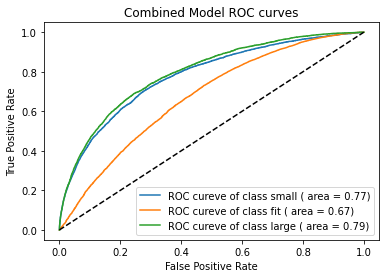

In [147]:
average_auc_score(interactionsTest,X_test)